In [14]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
import pywt
%matplotlib inline

# Data Preprocessing

In [40]:
face_cascade = cv2.CascadeClassifier('opencv/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('opencv/haarcascade_eye.xml')


In [54]:
def crop_img_2eye(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,255,255),2)
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >=2:
            return roi_color
            

In [55]:
path_to_data = "./data/"
path_to_cr_data = "./data/cropped/"


import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [56]:
img_dirs

['./data/Akshay_kumar', './data/cropped', './data/Depika', './data/SRK']

In [58]:

import shutil
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)



In [59]:

cropped_image_dirs = []
for img_dir in img_dirs:
#     print(img_dir)
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    for entry in os.scandir(img_dir):
#         print(entry.path)
        try:
            roi_color = crop_img_2eye(entry.path)
        except:
            continue
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name
            cv2.imwrite(cropped_file_path, roi_color)
            count += 1

Generating cropped images in folder:  ./data/cropped/Akshay_kumar
Generating cropped images in folder:  ./data/cropped/Depika
Generating cropped images in folder:  ./data/cropped/SRK


In [60]:
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list
celebrity_file_names_dict

{'Akshay_kumar': ['./data/cropped/Akshay_kumar\\Akshay_kumar1.png',
  './data/cropped/Akshay_kumar\\Akshay_kumar10.png',
  './data/cropped/Akshay_kumar\\Akshay_kumar11.png',
  './data/cropped/Akshay_kumar\\Akshay_kumar12.png',
  './data/cropped/Akshay_kumar\\Akshay_kumar13.png',
  './data/cropped/Akshay_kumar\\Akshay_kumar14.png',
  './data/cropped/Akshay_kumar\\Akshay_kumar15.png',
  './data/cropped/Akshay_kumar\\Akshay_kumar16.png',
  './data/cropped/Akshay_kumar\\Akshay_kumar17.png',
  './data/cropped/Akshay_kumar\\Akshay_kumar18.png',
  './data/cropped/Akshay_kumar\\Akshay_kumar19.png',
  './data/cropped/Akshay_kumar\\Akshay_kumar2.png',
  './data/cropped/Akshay_kumar\\Akshay_kumar20.png',
  './data/cropped/Akshay_kumar\\Akshay_kumar21.png',
  './data/cropped/Akshay_kumar\\Akshay_kumar22.png',
  './data/cropped/Akshay_kumar\\Akshay_kumar23.png',
  './data/cropped/Akshay_kumar\\Akshay_kumar24.png',
  './data/cropped/Akshay_kumar\\Akshay_kumar25.png',
  './data/cropped/Akshay_kumar\\

In [61]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'Akshay_kumar': 0, 'Depika': 1, 'SRK': 2}

In [62]:

import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img

    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;

    coeffs=pywt.wavedec2(imArray, mode, level=level)


    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

In [63]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])

In [64]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(241, 4096)

In [65]:
from collections import Counter
Counter(y)

Counter({0: 65, 1: 94, 2: 82})

In [183]:
X = StandardScaler().fit(X).transform(X)

In [358]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=10)


# Modeling

In [185]:

from sklearn.naive_bayes import GaussianNB

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

## Hyper Parameter Tunning

In [371]:

model_params = {
    'SVM': {
        'model': SVC(),
        'params': {
             'C': [1,10,20],
             'kernel': ['rbf','linear'],
             'gamma': ['auto', 'scale']
        }
    },
    
    
    'RANDOM_FOREST':{
        'model' : RandomForestClassifier(),
        'params': {
            'n_estimators':[5,10,20,40,50,60,100],
            'criterion': ['gini','entropy'],
            'max_depth': [None, 2,4],

        }
    },
    
    
    
    'LOGISTIC_REGRESSION': {
        'model': LogisticRegression(max_iter=200),
        'params': {
            'C': [1,5,10],
            'solver' : [ 'liblinear', 'lbfgs']
        }
    },
    
    
    'NAIVE_BAYES': {
        'model': GaussianNB(),
        'params':{
            'priors':[None]
        }
    },
    
    'ADABOOST': {
        'model': AdaBoostClassifier(),
        'params':{
            'n_estimators': [5,10,50,70]      
        }
    },
    
    
    'DecisionTree':{
        'model':DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini','entropy'],
            'max_depth': [None,4,7]
        }
    },
    
    
    'KNN':{
        'model':KNeighborsClassifier(),
        'params':{
            'n_neighbors':[2,4,5,6,7,8,9,10]       
        }
    },
    
    
    'xgboost':{
        'model':XGBClassifier(),
        'params':{
            'subsample':[0.8],
            'n_estimators':[25,50,100,150],
            'learning_rate':[0.03,0.05,0.07,0.1,0.2],
            'max_depth':[2,3,4,5],
            'random_state':[0,5]
            
            
        }
    }
    
}

In [372]:
scores=[]
best_estimators = {}

In [373]:
%%timeit


for model_name, mp in model_params.items():
    clf = GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': str(clf.best_params_)
    })
    best_estimators[model_name] = clf.best_estimator_


325 ms ± 2.43 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [374]:
import pandas as pd    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df = df.sort_values(by='best_score',ascending=False)
df

,model,best_score,best_params
0,SVM,0.902857,"{'C': 10, 'gamma': 'scale', 'kernel': 'linear'}"
1,SVM,0.902857,"{'C': 10, 'gamma': 'scale', 'kernel': 'linear'}"
2,SVM,0.902857,"{'C': 10, 'gamma': 'scale', 'kernel': 'linear'}"
3,SVM,0.902857,"{'C': 10, 'gamma': 'scale', 'kernel': 'linear'}"
4,SVM,0.902857,"{'C': 10, 'gamma': 'scale', 'kernel': 'linear'}"
5,SVM,0.902857,"{'C': 10, 'gamma': 'scale', 'kernel': 'linear'}"
6,SVM,0.902857,"{'C': 10, 'gamma': 'scale', 'kernel': 'linear'}"
7,SVM,0.902857,"{'C': 10, 'gamma': 'scale', 'kernel': 'linear'}"


In [375]:
df.drop_duplicates()

,model,best_score,best_params
0,SVM,0.902857,"{'C': 10, 'gamma': 'scale', 'kernel': 'linear'}"


 ## Evaluation

In [260]:
best_estimators['SVM'].score(X_test,y_test)

0.9259259259259259

In [262]:
best_estimators['RANDOM_FOREST'].score(X_test,y_test)

0.9629629629629629

In [263]:
best_estimators['LOGISTIC_REGRESSION'].score(X_test,y_test)

0.9259259259259259

In [264]:
best_estimators['NAIVE_BAYES'].score(X_test,y_test)

0.7407407407407407

In [265]:
best_estimators['ADABOOST'].score(X_test,y_test)

0.8518518518518519

In [266]:
best_estimators['DecisionTree'].score(X_test,y_test)

0.8518518518518519

In [267]:
best_estimators['KNN'].score(X_test,y_test)

0.8888888888888888

In [268]:
best_estimators['xgboost'].score(X_test,y_test)

0.8888888888888888

In [363]:
best_clf = best_estimators['RANDOM_FOREST']
best_clf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [364]:
from sklearn.metrics import classification_report
print(classification_report(y_test,best_clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       1.00      0.86      0.92         7

    accuracy                           0.96        27
   macro avg       0.98      0.93      0.95        27
weighted avg       0.96      0.96      0.96        27



In [365]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[20,  0],
       [ 1,  6]], dtype=int64)

Text(69.0, 0.5, 'Truth')

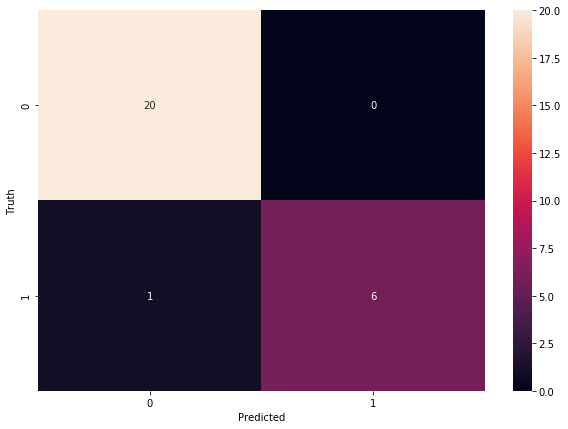

In [366]:
import seaborn as sns 
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [367]:
class_dict

{'depika': 0, 'srk': 1}

## Save Model

In [368]:
import joblib
joblib.dump(best_clf, 'saved_model.pkl')

['saved_model.pkl']

## Save Class

In [370]:

import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))